Notebook used to create OpenDataGen-factuality-en-v0.1 - https://huggingface.co/datasets/thoddnn/OpenDataGen-factuality-en-v0.1

Methodology:

1) Retrieve random article content from the HuggingFace Wikipedia English dataset.
2) Construct a Chain of Thought (CoT) to generate a Multiple Choice Question (MCQ).
3) Utilize a Large Language Model (LLM) to filter the results.

All these steps are prompted in the 'template.json' file located in the specified folder.

Should you have any inquiries or require further clarification, please do not hesitate to contact me on LinkedIn (https://www.linkedin.com/in/thomasdordonne/) or Twitter (https://twitter.com/thoDdnn).

In [ ]:
!pip install opendatagen --upgrade --force-reinstall
!pip install matplotlib

In [ ]:
!export OPENAI_API_KEY='your_openai_api_key' 
!export MISTRAL_API_KEY='your_mistral_api_key'
!export TOGETHER_API_KEY='your_together_api_key'

In [34]:
import pandas as pd 
from opendatagen.data_generator import DataGenerator
from opendatagen.model import OpenAIChatModel, MistralChatModel, TogetherChatModel, LlamaCPPModel
from opendatagen.template import TemplateManager
from mistralai.models.chat_completion import ChatMessage
import json
import random
import matplotlib.pyplot as plt
import pandas as pd

template_file_path = "template.json"
template_name = "opendataeval"
output_path = "OpenDataGen-factuality-en-v0.1-RAW.csv"
clean_output_path = "OpenDataGen-factuality-en-v0.1.csv"

Step 1: Generate the raw dataset using OpenDataGen

In [ ]:
manager = TemplateManager(template_file_path=template_file_path)
template = manager.get_template(template_name=template_name)

if template:
    
    generator = DataGenerator(template=template)
    
    data = generator.generate_data(output_path=output_path)
    
    print(data)

else: 

    print("The predefined template is badly formatted")

Step 2: Clean the CSV file by filtering for score = 1 with a confidence level > 0.9

In [ ]:
# Load the CSV file
df = pd.read_csv(output_path)

# Initialize a list to store the processed rows
processed_rows = []

for index , row in df.iterrows():
    if row['confidence_score'] > 0.9 and int(row['score']) == 1:
        # Parse the question and answer options
        question = row['question']

         # Attempt to parse the answer_options JSON
        try:
            answer_options = json.loads(row['answer_options'])
        except json.JSONDecodeError:
            # If answer_options is not a valid JSON, skip this row and continue with the next one
            continue
 
        # Extract the correct answer before shuffling
        correct_answer_text = answer_options['A']
        
        # Shuffle the answer options
        answers = list(answer_options.values())
        random.shuffle(answers)

         # Ensure there are exactly four answer options before assigning them
        if len(answers) != 4:
            # If there are not exactly four answers, skip this row and continue with the next one
            continue
        
        # Assign the shuffled answers to A, B, C, D
        shuffled_options = {'A': answers[0], 'B': answers[1], 'C': answers[2], 'D': answers[3]}
        
        # Find the key (A, B, C, or D) of the correct answer after shuffling
        correct_answer_key = [key for key, value in shuffled_options.items() if value == correct_answer_text][0]
        
        # Format the MCQ string
        mcq_string = f"""{question}\n\nA: {shuffled_options['A']}\nB: {shuffled_options['B']}\nC: {shuffled_options['C']}\nD: {shuffled_options['D']}"""
        
        # Add to the processed rows
        processed_rows.append({
            'MCQ': mcq_string,  # Add the MCQ formatted string
            'question': question,
            **shuffled_options,  # This unpacks the shuffled options A, B, C, D
            'correct_answer': correct_answer_key # Save the key where the correct answer ended up
            
        })

# Create a new dataframe from the processed rows
processed_df = pd.DataFrame(processed_rows)

# Save the processed dataframe to a new CSV named 'final_eval.csv'
processed_df.to_csv(clean_output_path, index=False)


Check for the answer distribution (A, B, C, D)

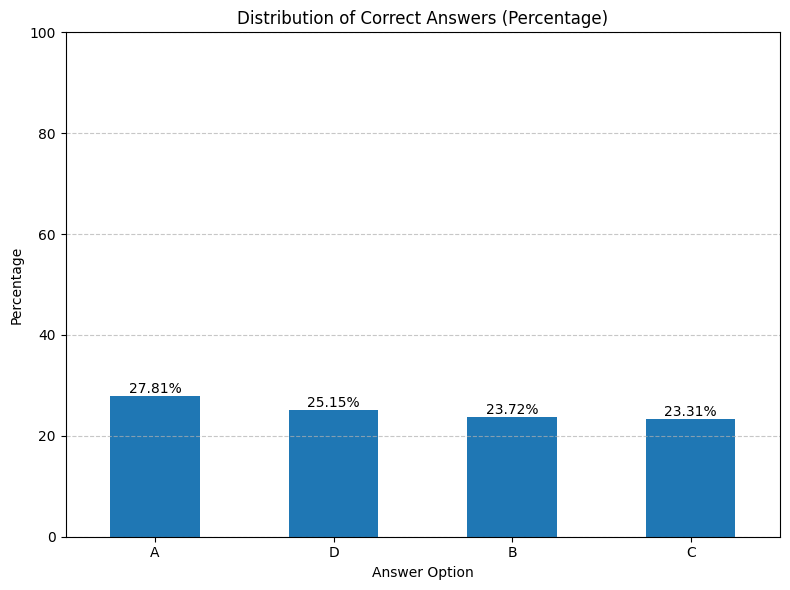

In [22]:
import matplotlib.pyplot as plt

# Calculate the percentage of each answer option
answer_percentage = processed_df['correct_answer'].value_counts(normalize=True) * 100

# Plot the distribution of the 'correct_answer' column as percentages with fixed y-axis from 0 to 100
plt.figure(figsize=(8, 6))
answer_percentage.plot(kind='bar')
plt.title('Distribution of Correct Answers (Percentage)')
plt.xlabel('Answer Option')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)  # Set y-axis to range from 0 to 100

# Add percentage values on top of each bar
for index, value in enumerate(answer_percentage):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()



Step 3: Evaluate LLMs 

For the code, to work you will need to have a Together AI, Mistral AI and OpenAI API keys. 
You will also need to download the GGUF file for Neural Beagle (https://huggingface.co/mlabonne/NeuralBeagle14-7B-GGUF) - use the 8 bit version

In [ ]:
import pandas as pd 
from opendatagen.data_generator import DataGenerator
from opendatagen.model import OpenAIChatModel, MistralChatModel, TogetherChatModel, LlamaCPPModel
from opendatagen.template import TemplateManager
from mistralai.models.chat_completion import ChatMessage
import pandas as pd
import json
import random
import matplotlib.pyplot as plt

models_to_test = {
    "Mistral 7B 0.2":TogetherChatModel(name="mistralai/Mistral-7B-Instruct-v0.2", max_tokens=1, temperature=[0]), 
    "OpenHermes 2.5":TogetherChatModel(name="teknium/OpenHermes-2p5-Mistral-7B", max_tokens=1, temperature=[0]), 
    "Neural Beagle":LlamaCPPModel(path="/path/NeuralBeagle14-7B-GGUF-v2/neuralbeagle14-7b.Q8_0.gguf", temperature=[0], max_tokens=1),
    "Mixtral":TogetherChatModel(name="mistralai/Mixtral-8x7B-Instruct-v0.1", max_tokens=1, temperature=[0]), 
    "Nous Mixtral":TogetherChatModel(name="NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO", max_tokens=1, temperature=[0]), 
    "Mistral Medium": MistralChatModel(name="mistral-medium", max_tokens=1, temperature=[0]),
    "GPT 3.5-Turbo": OpenAIChatModel(name="gpt-3.5-turbo-1106", max_tokens=1, temperature=[0]),
    "GPT 4-Turbo": OpenAIChatModel(name="gpt-4-1106-preview", max_tokens=1, temperature=[0])
}

# Load data
df = pd.read_csv(clean_output_path)

# Initialize counters
true_counts = {model_name: 0 for model_name in list(models_to_test.keys())}
total_counts = {model_name: 0 for model_name in list(models_to_test.keys())}

def ask_model(model, question):

    if isinstance(model, TogetherChatModel):

        messages = [
            {"role": "system", "content": "Answer to the question.\nYou must answer only with 'A', 'B', 'C' or 'D'"},
            {"role": "user", "content": f"Question:\n{question}"}
        ]

    elif isinstance(model, LlamaCPPModel): 

        messages = f"Answer to the question.\nYou must answer only with 'A', 'B', 'C' or 'D'\n\nQuestion:{question}\nAnswer:"
    
    elif isinstance(model, OpenAIChatModel):

        messages = [
            {"role": "system", "content": "Answer to the question.\nYou must answer only with 'A', 'B', 'C' or 'D'"},
            {"role": "user", "content": f"Question:\n{question}"}
        ]
    
    elif isinstance(model, MistralChatModel):

        messages = [
            ChatMessage(role="system", content="Answer to the question.\nYou must answer only with 'A', 'B', 'C' or 'D'"),
            ChatMessage(role="user", content=f"Question:\n{question}")
        ]

    else: 

        raise ValueError(f'Unknown model type: {model.name}')

    return model.ask(messages=messages)

# Evaluation loop
for index, row in df.iterrows():
    question = row['MCQ']

    correct_answer = row['correct_answer']
    
    for model_name, model in models_to_test.items():
        
        model_answer = ask_model(model, question)

        if correct_answer.lower() == model_answer.lower():
            true_counts[model_name] += 1
        total_counts[model_name] += 1


# Calculate and display the results
for model_name in true_counts:
    accuracy = (true_counts[model_name] / total_counts[model_name]) * 100
    print(f"Model {model_name}: {accuracy:.2f}% True answers")

Step 4: Plot the result

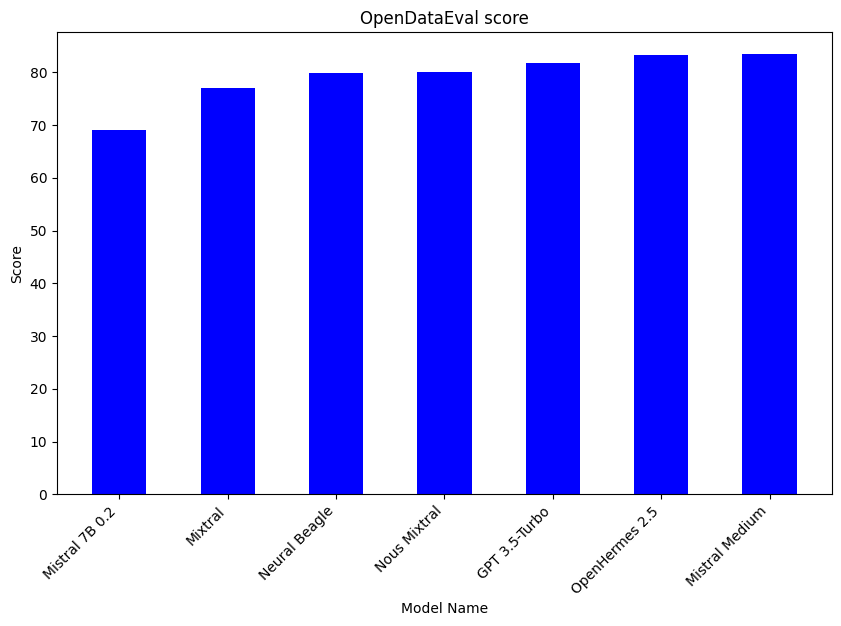

In [44]:
import matplotlib.pyplot as plt

# Calculate accuracies
accuracies = {model_name: (true_counts[model_name] / total_counts[model_name]) * 100 for model_name in true_counts}

# Sort the accuracies dictionary by its values (accuracy percentages)
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1]))

# Names of models sorted by accuracy
model_names = list(sorted_accuracies.keys())

# Sorted accuracy values
accuracy_values = list(sorted_accuracies.values())

# Set figure size (width, height)
plt.figure(figsize=(10, 6))  # You can adjust the size as per your requirement

# Create a bar chart
# Adjust the width of the bars (e.g., 0.5)
plt.bar(model_names, accuracy_values, color='blue', width=0.5)

# Adding title and labels
plt.title('OpenDataEval score')
plt.xlabel('Model Name')
plt.ylabel('Score')

# Optionally, you can rotate the model names on the x-axis for better readability
plt.xticks(rotation=45, ha='right')

# Save the plot as an image file
plt.savefig('comparison.png')  #You can change the file name and format (e.g., .jpg, .png, etc.)

# Show the plot
plt.show()
